In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling pre-processing with scikit-learn functionality
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
# Modeling pre-processing with non-scikit-learn packages
from category_encoders.ordinal import OrdinalEncoder
from feature_engine.encoding import RareLabelEncoder
import xgboost as xgb
# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV


from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform
from scipy.stats import randint
from plotnine import *
from sklearn.inspection import partial_dependence





In [31]:
housing = pd.read_csv("../data/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Dummy Encoding

In [32]:
# dummy encode
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# apply to all categorical features
dummy_encoder = ColumnTransformer([("dummy", encoder, selector(dtype_include="object"))])

### Filter out zero or near-zero variance features.

In [33]:
housing.var()

/tmp/ipykernel_28884/2527284353.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  housing.var()


longitude             4.014139e+00
latitude              4.562293e+00
housing_median_age    1.583963e+02
total_rooms           4.759445e+06
total_bedrooms        1.775654e+05
population            1.282470e+06
households            1.461760e+05
median_income         3.609323e+00
median_house_value    1.331615e+10
dtype: float64

In [34]:
nzv = VarianceThreshold(threshold=0.1)

### Imputation

In [35]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [36]:
knn_imp = KNNImputer(n_neighbors=6)

In [72]:
bedrooms_mean = float(int(housing["total_bedrooms"].mean()))
housing["total_bedrooms"].fillna(bedrooms_mean, inplace = True)

In [73]:
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [74]:
# create train/test split
train, test = train_test_split(housing, train_size=0.7, random_state=123)

In [75]:
# separate features from labels and only use numeric features
X_train = train.drop("median_house_value", axis=1)
y_train = train[["median_house_value"]]

In [76]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

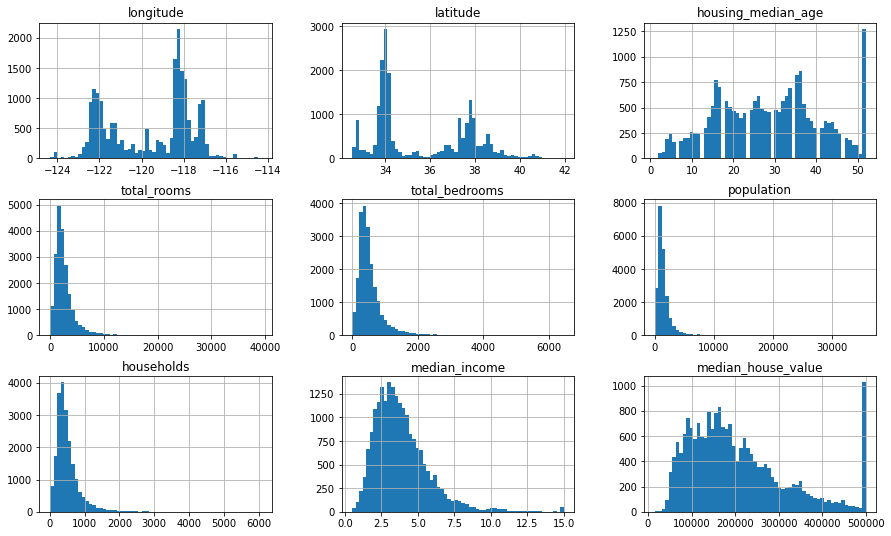

In [77]:
housing.hist(bins=60, figsize=(15,9));plt.show()

###  solving Skewness using yeo-johnson

In [78]:
X_norm = ColumnTransformer([("norm",  PowerTransformer(method = "yeo-johnson"), selector(dtype_include="number"))])

### Standardization

In [79]:
scaler = StandardScaler()

# standardize all numeric features
std = ColumnTransformer([("norm", scaler, selector(dtype_include="number"))])

In [80]:
# pca = PCA(n_components=30)


In [81]:
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("nzv_encode", nzv, selector(dtype_include="number")),

  ("std_encode", scaler, selector(dtype_include="number")),
 
  ("one-hot", encoder, selector(dtype_include="object")),
  ])

In [82]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('nzv_encode', VarianceThreshold(threshold=0.1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd90fa14fa0>),
                                ('std_encode', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd90fa14c40>),
                                ('one-hot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd90fa14d00>)])

In [48]:
xgb_mod = xgb.XGBRegressor()

# create modeling pipeline 
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("xgb_mod", xgb_mod),
])

# define loss function
loss = 'neg_root_mean_squared_error'

# create 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# fit model with 5-fold CV
results = cross_val_score(model_pipeline, X_train, y_train, cv=kfold, scoring=loss)

In [49]:
hyper_grid = {
  'xgb_mod__n_estimators': [1000, 2500, 5000],
  'xgb_mod__learning_rate': [0.001, 0.01, 0.1],
  'xgb_mod__max_depth': [3, 5, 7, 9],
  'xgb_mod__min_child_weight': [1, 5, 15] 
}

In [50]:
random_search = RandomizedSearchCV(
    model_pipeline, 
    param_distributions=hyper_grid, 
    n_iter=20, 
    cv=kfold, 
    scoring=loss, 
    n_jobs=-1, 
    random_state=13
)

In [51]:
random_search_results = random_search.fit(X_train, y_train)

In [55]:
np.abs(random_search_results.best_score_)

47301.58087750292

In [56]:
random_search_results.best_params_

{'xgb_mod__n_estimators': 5000,
 'xgb_mod__min_child_weight': 15,
 'xgb_mod__max_depth': 5,
 'xgb_mod__learning_rate': 0.01}

In [57]:
xgb_mod = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1
)

# create modeling pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("xgb_mod", xgb_mod),
])

## Stochastic GBMs

In [58]:
stochastic_hyper_grid = {
  'xgb_mod__subsample': [0.5, 0.75, 1],
  'xgb_mod__colsample_bytree': [0.5, 0.75, 1],
  'xgb_mod__colsample_bylevel': [0.5, 0.75, 1],
  'xgb_mod__colsample_bynode': [0.5, 0.75, 1]
}

stochastic_random_search = RandomizedSearchCV(
    model_pipeline, 
    param_distributions=stochastic_hyper_grid, 
    n_iter=20, 
    cv=kfold, 
    scoring=loss, 
    n_jobs=-1, 
    random_state=13
)

In [59]:
stochastic_random_search_results = stochastic_random_search.fit(X_train, y_train)

In [60]:
np.abs(stochastic_random_search_results.best_score_)

47775.89249567003

In [61]:
stochastic_random_search_results.best_params_

{'xgb_mod__subsample': 0.75,
 'xgb_mod__colsample_bytree': 0.75,
 'xgb_mod__colsample_bynode': 1,
 'xgb_mod__colsample_bylevel': 1}

## Regularized GBMs

In [62]:
xgb_mod = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=0.75,
    colsample_bylevel=0.75,
    colsample_bynode=0.75
)

# create modeling pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("xgb_mod", xgb_mod),
])

In [63]:
regularization_hyper_grid = {
  'xgb_mod__gamma': [0, 0.1, 10, 1000],
  'xgb_mod__alpha': [0, 0.1, 10, 1000],
  'xgb_mod__lambda': [0, 0.1, 10, 1000]
}

regularization_random_search = RandomizedSearchCV(
    model_pipeline, 
    param_distributions=regularization_hyper_grid, 
    n_iter=20, 
    cv=kfold, 
    scoring=loss, 
    n_jobs=-1, 
    random_state=13
)



In [64]:
%%time
regularization_random_search_results = regularization_random_search.fit(X_train, y_train)

CPU times: user 5min 52s, sys: 400 ms, total: 5min 53s
Wall time: 4min 46s


In [65]:
np.abs(regularization_random_search_results.best_score_)

47497.179186760106

## create random forest estimator


In [68]:
rf_mod = RandomForestRegressor()

# create modeling pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("rf_mod", rf_mod),
])

In [83]:
X_train.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
dtype: int64

In [84]:
results = cross_val_score(model_pipeline, X_train, y_train.values.ravel(), cv=kfold, scoring=loss)


In [88]:
np.abs(np.mean(results))

50551.6148922606

In [89]:
# create random forest estimator with 1,000 trees
rf_mod = RandomForestRegressor(n_estimators=1000)

# create modeling pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("rf_mod", rf_mod),
])

# Create grid of hyperparameter values
hyper_grid = {
  'rf_mod__max_features': [.05, .15, .25, .333, .4],
  'rf_mod__min_samples_leaf': [1, 3, 5, 10],
  'rf_mod__bootstrap': [True, False],
  'rf_mod__max_samples': [.5, .63, .8]
  }
  
# Tune a knn model using grid search
grid_search = GridSearchCV(model_pipeline, hyper_grid, cv=kfold, scoring=loss, n_jobs=-1)
results = grid_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

In [90]:
np.abs(results.best_score_)

49812.65625478207

In [91]:
results.best_params_

{'rf_mod__bootstrap': True,
 'rf_mod__max_features': 0.333,
 'rf_mod__max_samples': 0.8,
 'rf_mod__min_samples_leaf': 1}

### Random grid search

In [95]:
# %% capture

# Create grid of hyperparameter values
hyper_distributions = {
  'rf_mod__max_features': uniform(.05, .35),
  'rf_mod__min_samples_leaf': randint(1, 9),
  'rf_mod__bootstrap': [True, False],
  'rf_mod__max_samples': uniform(.5, .3)
  }
  
# Tune a knn model using grid search
random_search = RandomizedSearchCV(
  model_pipeline, 
  param_distributions=hyper_distributions, 
  n_iter=20,
  cv=kfold, 
  scoring=loss, 
  n_jobs=-1, 
  random_state=13
  )
random_search_results = random_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

In [96]:
np.abs(random_search_results.best_score_)

50133.500254598825

In [101]:
# create final model object
X_encoded = preprocessor.fit_transform(X_train)
final_model = RandomForestRegressor(
  n_estimators=1000,
  max_features=0.21,
  max_samples=0.65,
  min_samples_leaf=1,
  bootstrap=True
)
final_model_fit = final_model.fit(X_encoded, y_train.values.ravel())

# extract feature importances
vi = pd.DataFrame({'feature': preprocessor.get_feature_names(),
                   'importance': final_model_fit.feature_importances_})

# get top 20 influential features
top_20_features = vi.nlargest(9, 'importance')

# plot feature importance
(ggplot(top_20_features, aes(x='importance', y='reorder(feature, importance)'))
 + geom_point()
 + labs(y=None))

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


AttributeError: Transformer nzv_encode (type VarianceThreshold) does not provide get_feature_names.

In [104]:
preprocessor.get_feature_names()

AttributeError: Transformer nzv_encode (type VarianceThreshold) does not provide get_feature_names.

In [103]:
vi = pd.DataFrame({'feature': preprocessor.get_feature_names(),
                   'importance': final_model_fit.feature_importances_})

AttributeError: Transformer nzv_encode (type VarianceThreshold) does not provide get_feature_names.

In [102]:
# get top 20 influential features
top_20_features = vi.nlargest(9, 'importance')

# plot feature importance
(ggplot(top_20_features, aes(x='importance', y='reorder(feature, importance)'))
 + geom_point()
 + labs(y=None))

NameError: name 'vi' is not defined

In [106]:
X_encoded = pd.DataFrame(X_encoded, columns=preprocessor.get_feature_names())
pd_results = partial_dependence(
  final_model_fit, X_encoded, "Gr_Liv_Area", kind='average',
  percentiles=(0, 1)) 
  
pd_output = pd.DataFrame({'Gr_Liv_Area': pd_results['values'][0],
                          'yhat': pd_results['average'][0]})
                          
(ggplot(pd_output, aes('Gr_Liv_Area', 'yhat'))
  + geom_line())

AttributeError: Transformer nzv_encode (type VarianceThreshold) does not provide get_feature_names.